In [17]:
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame
from matplotlib import gridspec
from scipy.stats import zscore
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

## Loading in the data

In [2]:
filename = 'data/N-CMAPSS_DS04.h5'

In [3]:
# time tracking
t = time.process_time()  

# loading data
with h5py.File(filename, 'r') as hdf:
        
        # development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.04453125

W shape: (9980013, 4)
X_s shape: (9980013, 14)
X_v shape: (9980013, 14)
T shape: (9980013, 10)
A shape: (9980013, 4)


In [4]:
# creating the dataframes for training
df_A_train = DataFrame(data=A_dev, columns=A_var)             # auxiliary information
df_W_train = DataFrame(data=W_dev, columns=W_var)             # operative conditions 
df_X_s_train = DataFrame(data=X_s_dev, columns=X_s_var)       # sensor readings
df_X_v_train = DataFrame(data=X_v_dev, columns=X_v_var)       # virtual sensors
df_T_train = DataFrame(data=T_dev, columns=T_var)             # degradation
df_Y_train = DataFrame(data=Y_dev)                            # RUL

# creating the dataframes for testing
df_A_test = DataFrame(data=A_test, columns=A_var)             # auxiliary information
df_W_test = DataFrame(data=W_test, columns=W_var)             # operative conditions 
df_X_s_test = DataFrame(data=X_s_test, columns=X_s_var)       # sensor readings
df_X_v_test = DataFrame(data=X_v_test, columns=X_v_var)       # virtual sensors
df_T_test = DataFrame(data=T_test, columns=T_var)             # degradation
df_Y_test = DataFrame(data=Y_test)                            # RUL

# concatinated DataFrames 
df_train = pd.concat([df_W_train, df_X_s_train, df_X_v_train, df_T_train, df_Y_train, df_A_train], axis=1)
df_test = pd.concat([df_W_test, df_X_s_test, df_X_v_test, df_T_test, df_Y_test, df_A_test], axis=1)

In [5]:
print(f"The train set of {filename} has {df_train.shape[0]} rows.")
print(f"The test set of {filename} has {df_test.shape[0]} rows.")

print("\n")

print(f"The units in the train set of {filename} are {df_train.unit.unique().tolist()}.")
print(f"The units in the test set of {filename} are {df_test.unit.unique().tolist()}.")

The train set of data/N-CMAPSS_DS04.h5 has 6377452 rows.
The test set of data/N-CMAPSS_DS04.h5 has 3602561 rows.


The units in the train set of data/N-CMAPSS_DS04.h5 are [1.0, 2.0, 3.0, 4.0, 5.0, 6.0].
The units in the test set of data/N-CMAPSS_DS04.h5 are [7.0, 8.0, 9.0, 10.0].


In [6]:
df_train

,alt,Mach,TRA,T2,T24,T30,T48,T50,P15,P2,...,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,0,unit,cycle,Fc,hs
0,3003.0,0.261135,81.386139,514.889127,620.536686,1500.497778,1918.887446,1305.895297,19.186726,13.769427,...,0.0,0.0,0.0,0.0,0.0,86,1.0,1.0,2.0,1.0
1,3014.0,0.260820,81.386139,514.832078,620.212233,1501.026264,1918.174792,1306.704845,19.168470,13.765780,...,0.0,0.0,0.0,0.0,0.0,86,1.0,1.0,2.0,1.0
2,3023.0,0.262521,81.386139,514.889656,620.691023,1501.435624,1917.553771,1305.988738,19.161991,13.768780,...,0.0,0.0,0.0,0.0,0.0,86,1.0,1.0,2.0,1.0
3,3032.0,0.262836,81.386139,514.874556,620.355416,1500.911321,1917.426968,1305.531529,19.171850,13.754179,...,0.0,0.0,0.0,0.0,0.0,86,1.0,1.0,2.0,1.0
4,3042.0,0.262332,81.386139,514.811204,620.591359,1501.437449,1918.752200,1305.696191,19.161257,13.744312,...,0.0,0.0,0.0,0.0,0.0,86,1.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6377447,3011.0,0.203490,24.345530,512.138842,564.042282,1274.996275,1500.417145,1141.806507,15.494480,13.506612,...,0.0,0.0,0.0,0.0,0.0,0,6.0,83.0,3.0,0.0
6377448,3009.0,0.203364,24.345530,512.140747,564.242173,1274.028094,1499.929273,1142.027811,15.487648,13.507595,...,0.0,0.0,0.0,0.0,0.0,0,6.0,83.0,3.0,0.0
6377449,3007.0,0.203301,24.345530,512.145375,564.082376,1275.203999,1501.079628,1140.562860,15.497077,13.502190,...,0.0,0.0,0.0,0.0,0.0,0,6.0,83.0,3.0,0.0
6377450,3005.0,0.201978,24.345530,512.098032,564.314003,1276.011975,1500.350509,1141.601479,15.497032,13.506941,...,0.0,0.0,0.0,0.0,0.0,0,6.0,83.0,3.0,0.0


In [7]:
# def filter_zeros(df, treshold = 1):
#     """Filtering out features that contain too many zero values"""
    
#     to_drop = []
#     zeros = df.apply(lambda x: sum(x == 0)).to_frame(name="count")

#     # fraction of acceptable zeros compared to total num of rows
#     frac = df.shape[0] * treshold

#     for i, row in zeros.iterrows():
#         if row["count"] >= frac:
#             to_drop.append(i)
    
#     df = df.drop(columns = to_drop)

#     return df

# df_train = filter_zeros(df_train)

## Pre-processing steps

In [9]:
# specifying what columns to remove per subset of the data (as they don't contain that failure mode)
fmodes_DS01 =  ['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod',
                'HPC_eff_mod', 'HPC_flow_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']

fmodes_DS04 =  ['LPC_eff_mod', 'LPC_flow_mod',
                'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod',
                'LPT_eff_mod', 'LPT_flow_mod']

fmodes_DS08 = []

In [10]:
def preprocessing(df, fmodes):
    '''Pre-processing pipeline for the N-CMAPSS dataset as described in the methodology'''

    # renaming RUL column
    col = list(df.columns)
    col[42]='RUL'
    df.columns = col

    # dropping columns 'P2' and 'T2' (and health state)
    df = df.drop(columns = ["P2", "T2"])

    # setting rolling window size 
    window_size = 100

    # selecting columns for noise reduction (sensor measurements & virtual readings)
    to_reduce = ['TRA', 'T24', 'T30', 'T48', 'T50', 'P15', 'P21', 'P24',
       'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf', 'T40', 'P30', 'P45', 'W21',
       'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC',
       'phi', 'fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod',
       'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod',
       'LPT_eff_mod', 'LPT_flow_mod']
    
    # part of dataframe that doesn't need noise reduction
    no_noise = df[['alt', 'Mach', 'RUL', 'unit', 'cycle', 'Fc', 'hs']]

    # calculate rolling average for each column base on window
    rolling_avg_df = df[to_reduce].rolling(window=window_size).mean()

    # fill in nan values with the original value 
    for col in to_reduce:
        rolling_avg_df.fillna({col: df[col]}, inplace=True)

    # concatenate both parts of dataframe back together 
    df_reduced = pd.concat([no_noise, rolling_avg_df], axis = 1)

    # calculating T30 - T24 & adding to dataframe
    df_reduced["dT_30_24"] = abs(df_reduced.T30 - df_reduced.T24)

    # calculating T50 - T40 & adding to dataframe 
    df_reduced["dT_50_40"] = abs(df_reduced.T50 - df_reduced.T40)

    # applying z-score normalization 
    df_reduced[to_reduce + ["dT_30_24", "dT_50_40"]] = df_reduced[to_reduce + ["dT_30_24", "dT_50_40"]].apply(zscore)

    # dropping failure modes not in current subset
    df_reduced = df_reduced.drop(columns = fmodes)

    return df_reduced


In [11]:
df_train_processed = preprocessing(df_train, fmodes_DS04)
df_test_processed = preprocessing(df_test, fmodes_DS04)

Text(0.5, 1.0, 'Pre-Processed Sensor Readings Correlating with RUL')

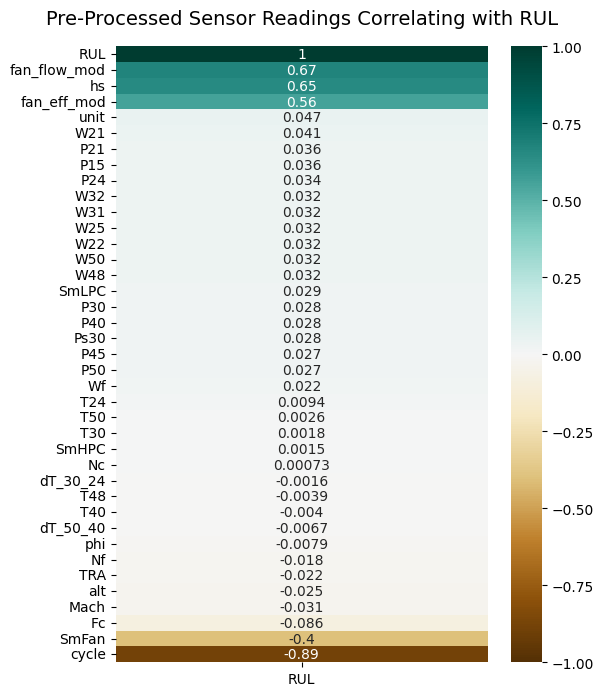

In [12]:
# correlation heatmap of RUL against all features
plt.figure(figsize=(6, 8))
sensor_readings_heatmap = sns.heatmap(df_train_processed.corr()[['RUL']].sort_values(by='RUL', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
sensor_readings_heatmap.set_title('Pre-Processed Sensor Readings Correlating with RUL', fontdict={'fontsize':14}, pad=16)

In [13]:
def low_correlation(df, treshold = 0.1):
    """Filtering out features that have an exteremely low correlation with the target value RUL"""

    # calculate correlations
    correlations = df.corr()[['RUL']]

    # list of columns to drop 
    to_drop = []

    # filter out correlations not above treshold
    for i, row in correlations.iterrows():
        feature = i
        RUL_c = row["RUL"]

        if abs(RUL_c) < treshold or RUL_c == np.nan:
            to_drop.append(feature)

    df = df.drop(columns=to_drop)
    return df 

In [14]:
df_train_processed = low_correlation(df_train_processed)
df_test_processed = low_correlation(df_test_processed)

In [15]:
df_train_processed

,RUL,cycle,hs,SmFan,fan_eff_mod,fan_flow_mod
0,86,1.0,1.0,-2.291206,0.474393,0.602657
1,86,1.0,1.0,-2.292622,0.474393,0.602657
2,86,1.0,1.0,-2.284678,0.474393,0.602657
3,86,1.0,1.0,-2.282645,0.474393,0.602657
4,86,1.0,1.0,-2.284794,0.474393,0.602657
...,...,...,...,...,...,...
6377447,0,83.0,0.0,-0.564930,-8.132114,-6.351499
6377448,0,83.0,0.0,-0.572231,-8.132114,-6.351499
6377449,0,83.0,0.0,-0.579495,-8.132114,-6.351499
6377450,0,83.0,0.0,-0.586834,-8.132114,-6.351499


## Linear Regression

In [ ]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

## Random Forest

In [16]:
# initiatinx trianing & test set
X_train = df_train_processed.drop(columns=["RUL"])
X_test = df_test_processed.drop(columns=["RUL"])

y_train = df_train_processed["RUL"]
y_test = df_test_processed["RUL"]

# fixing error
X_train = X_train.rename(str, axis = "columns") 
X_test = X_test.rename(str, axis = "columns") 

# initialize the Random Forest regressor
rf_regressor = RandomForestRegressor()

# train the Random Forest regressor
rf_regressor.fit(X_train, y_train)

# predict RUL on the test set
y_pred = rf_regressor.predict(X_test)

# calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)


R-squared: 0.7623070441448563
Root Mean Squared Error (RMSE): 12.33681293376249


c:\Users\k101210\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
